In [1]:
from binance.client import Client
import pandas as pd
import ta 
import time
import matplotlib.pyplot as plt 

In [2]:
# Binance API keys
API_KEY = '3KKoPw7y0uHyLzFVnwxu6gsXFQfBEDwnoLDpKjbh41UgvbB3LukYx0zhsG5l1xev'
API_SECRET = 'PmJwK0lzZiQ5cCEW2aypB8Eska7bHiJ3gmOY6WyetmTm7C7FxCKBkfvYJR3Wzhky'

# Initialize Binance client
client = Client(API_KEY, API_SECRET)

In [3]:
client

In [4]:
def getDate(symbol):
    # Get 1 day candlestick data for the last 1 year
    klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, "1 year ago UTC")
    df = pd.DataFrame(klines, columns=['time', 'open', 'high', 'low', 'close', 'volume', 
                                       'close_time', 'quote_asset_volume', 'trades', 
                                       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df['close'] = df['close'].astype(float)
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['volume'] = df['volume'].astype(float)
    return df[['time', 'open', 'high', 'low', 'close', 'volume']]

In [5]:
# getDate('BTCUSDT')
# getDate('ETHUSDT')
getDate('ADAUSDT')


,time,open,high,low,close,volume
0,2023-11-26,0.3942,0.3956,0.3782,0.3873,6.446507e+07
1,2023-11-27,0.3874,0.3922,0.3712,0.3777,7.066935e+07
2,2023-11-28,0.3778,0.3883,0.3693,0.3858,7.917439e+07
3,2023-11-29,0.3857,0.3892,0.3775,0.3816,6.820052e+07
4,2023-11-30,0.3817,0.3829,0.3719,0.3759,5.993046e+07
...,...,...,...,...,...,...
361,2024-11-21,0.8003,0.8239,0.7655,0.8218,4.867015e+08
362,2024-11-22,0.8219,1.0440,0.8123,1.0175,1.031366e+09
363,2024-11-23,1.0175,1.1542,1.0157,1.0658,9.197637e+08
364,2024-11-24,1.0659,1.0978,0.9364,1.0226,5.813572e+08


In [6]:
# Trading function with graph display
def tradingGraph(symbol, qty, open_position=False):
    try:
        buy_signals = []
        sell_signals = []
        buyPrices = []
        sellPrices = []
        
        while True:
            # Fetch data
            df = getDate(symbol)

            # Ensure data is fetched
            if df.empty:
                print("No data fetched, retrying...")
                time.sleep(5)
                continue

            # Calculate MACD and MACD Signal
            macd_indicator = ta.trend.MACD(df['close'])
            df['macd_diff'] = macd_indicator.macd_diff()

            # Check conditions
            if not open_position:
                # Buy condition: MACD diff crosses above 0
                if df['macd_diff'].iloc[-1] > 0 and df['macd_diff'].iloc[-2] < 0:
                    order = client.create_order(
                        symbol=symbol, side='BUY', type='MARKET', quantity=qty
                    )
                    print("BUY ORDER:", order)
                    open_position = True
                    buyPrice = float(order['fills'][0]['price'])
                    buy_signals.append(df['time'].iloc[-1])
                    buyPrices.append(buyPrice)
            else:
                # Sell condition: MACD diff crosses below 0
                if df['macd_diff'].iloc[-1] < 0 and df['macd_diff'].iloc[-2] > 0:
                    order = client.create_order(
                        symbol=symbol, side='SELL', type='MARKET', quantity=qty
                    )
                    print("SELL ORDER:", order)
                    sellPrice = float(order['fills'][0]['price'])
                    print(f"Profit = {(sellPrice - buyPrice) / buyPrice * 100:.2f}%")
                    open_position = False
                    sell_signals.append(df['time'].iloc[-1])
                    sellPrices.append(sellPrice)

            # Plotting
            plt.figure(figsize=(12, 6))
            plt.subplot(2, 1, 1)  # Price chart
            plt.plot(df['time'], df['close'], label='Price', color='blue')
            plt.scatter(buy_signals, buyPrices, marker='^', color='green', label='Buy Signal', alpha=1)
            plt.scatter(sell_signals, sellPrices, marker='v', color='red', label='Sell Signal', alpha=1)
            plt.title(f'{symbol} Price with Buy/Sell signals')
            plt.legend()

            # MACD chart
            plt.subplot(2, 1, 2)
            plt.plot(df['time'], df['macd_diff'], label='MACD Diff', color='orange')
            plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
            plt.title('MACD Difference')
            plt.legend()

            plt.tight_layout()
            plt.show()

            # Wait before next check
            time.sleep(60)  # Adjust this interval as per your trading needs
    except Exception as e:
        print(f"Error in trading loop: {e}")



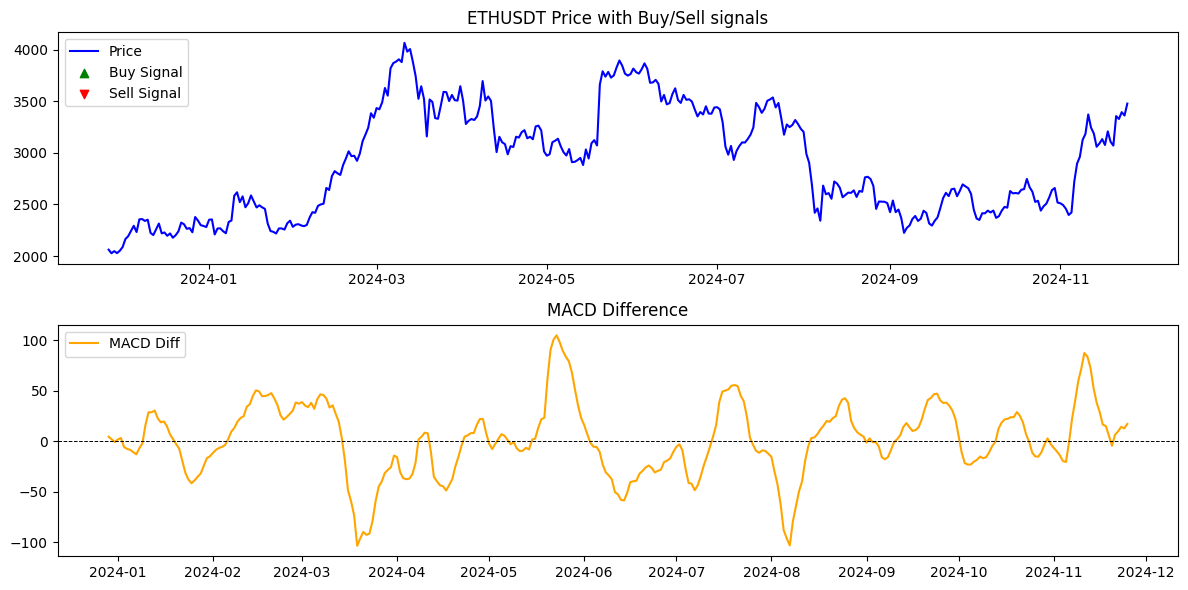

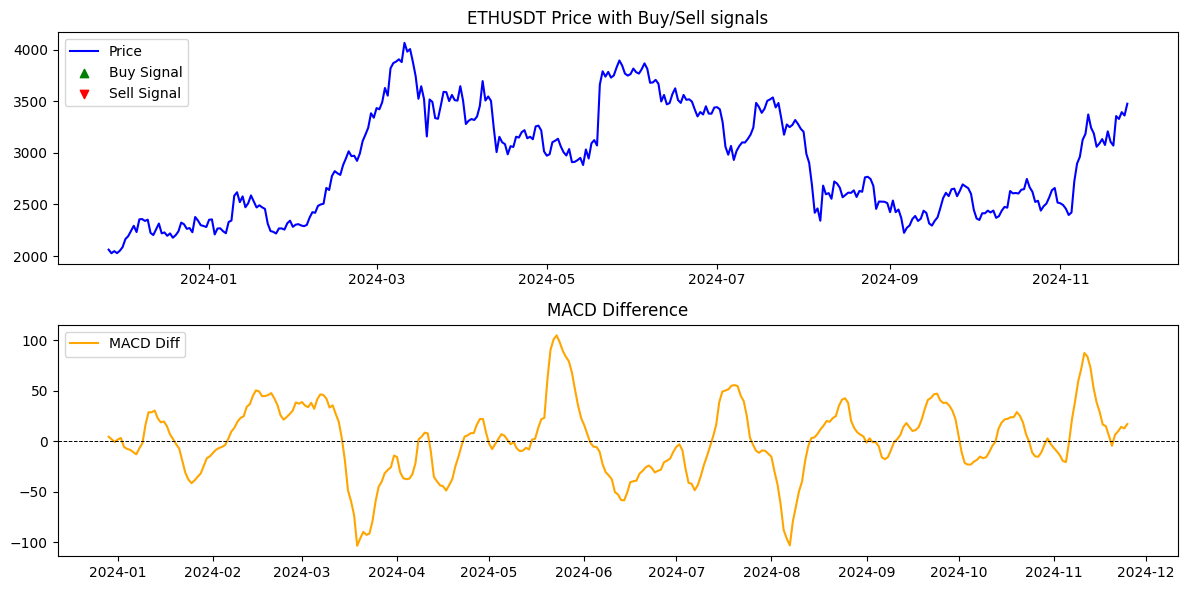

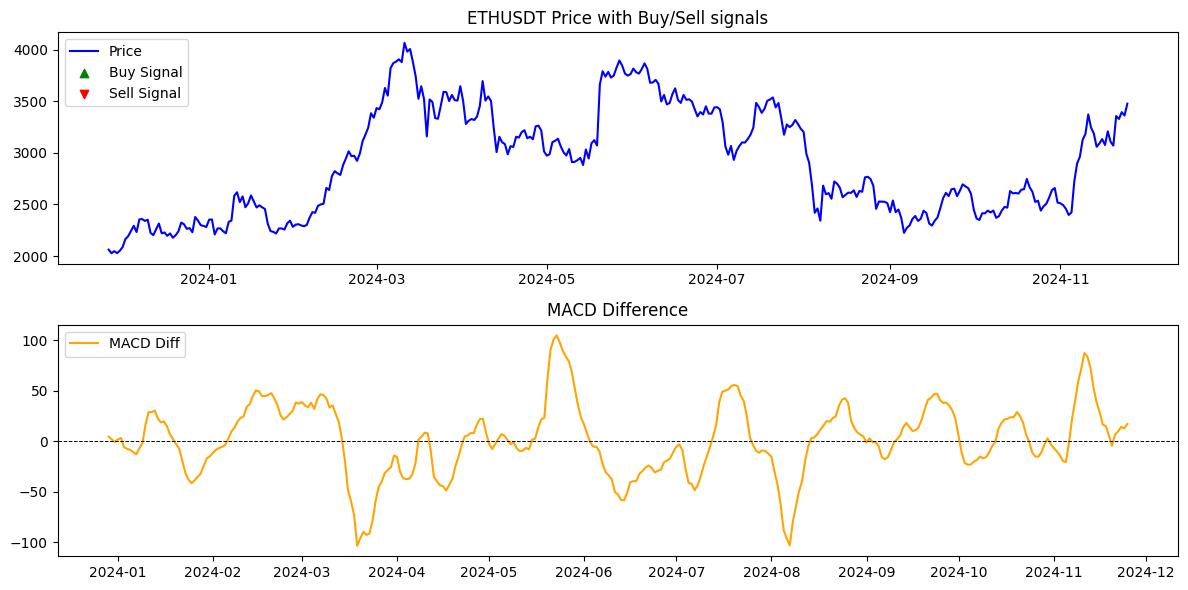

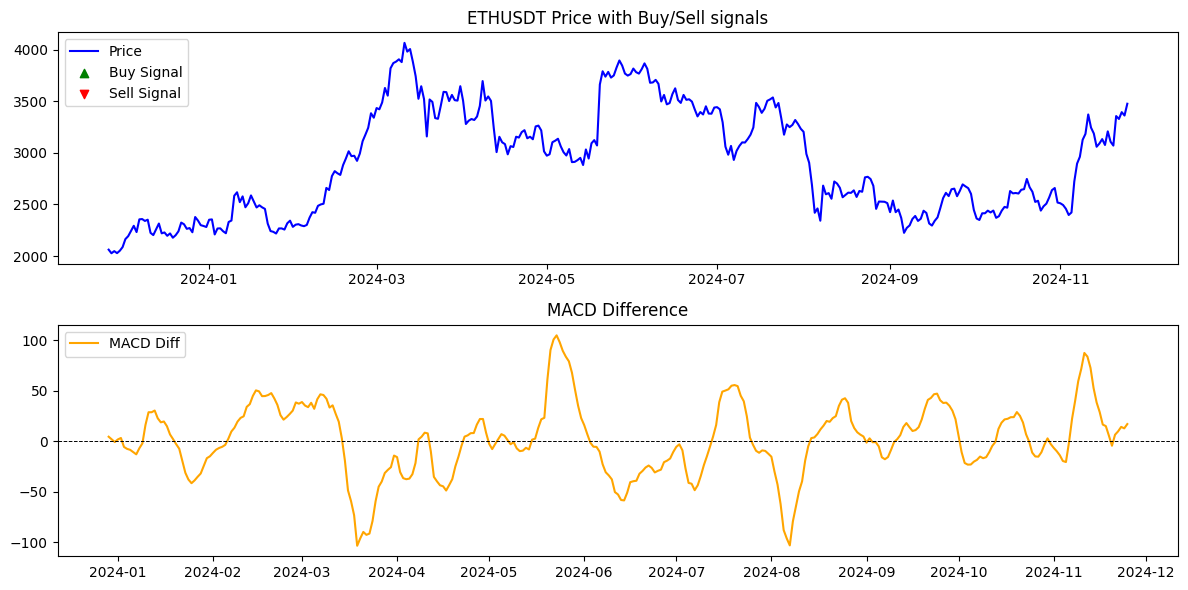

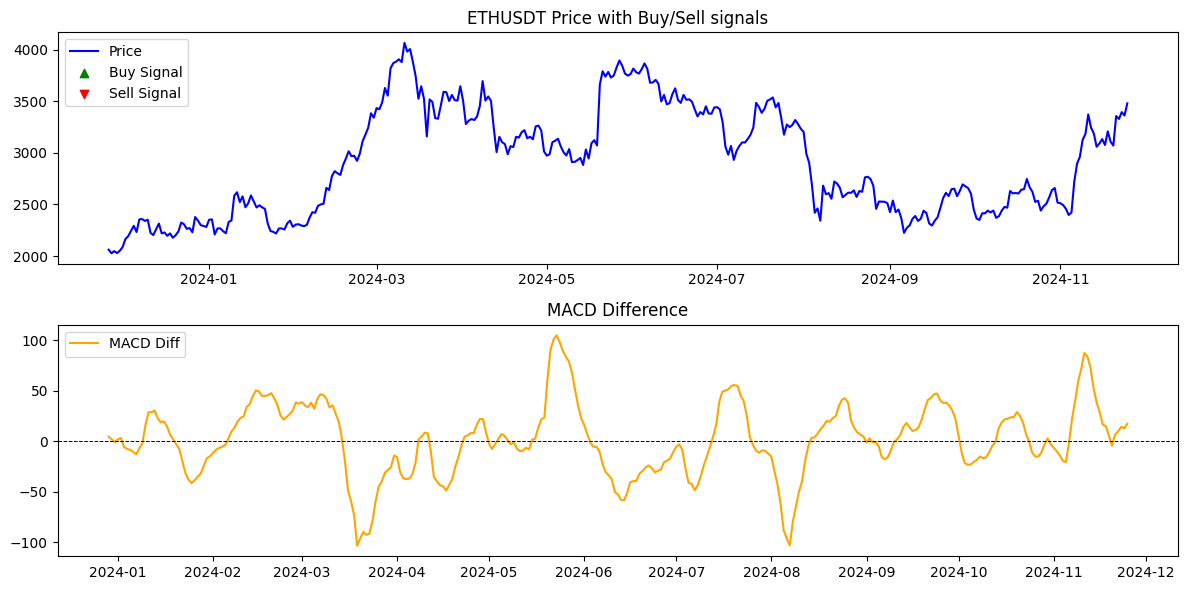

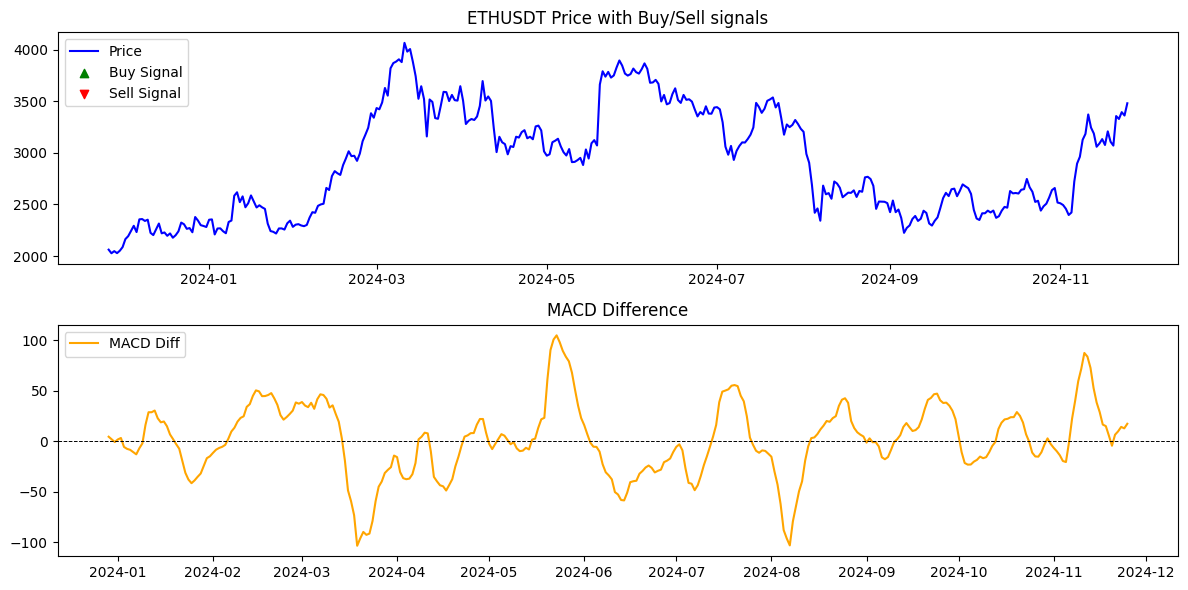

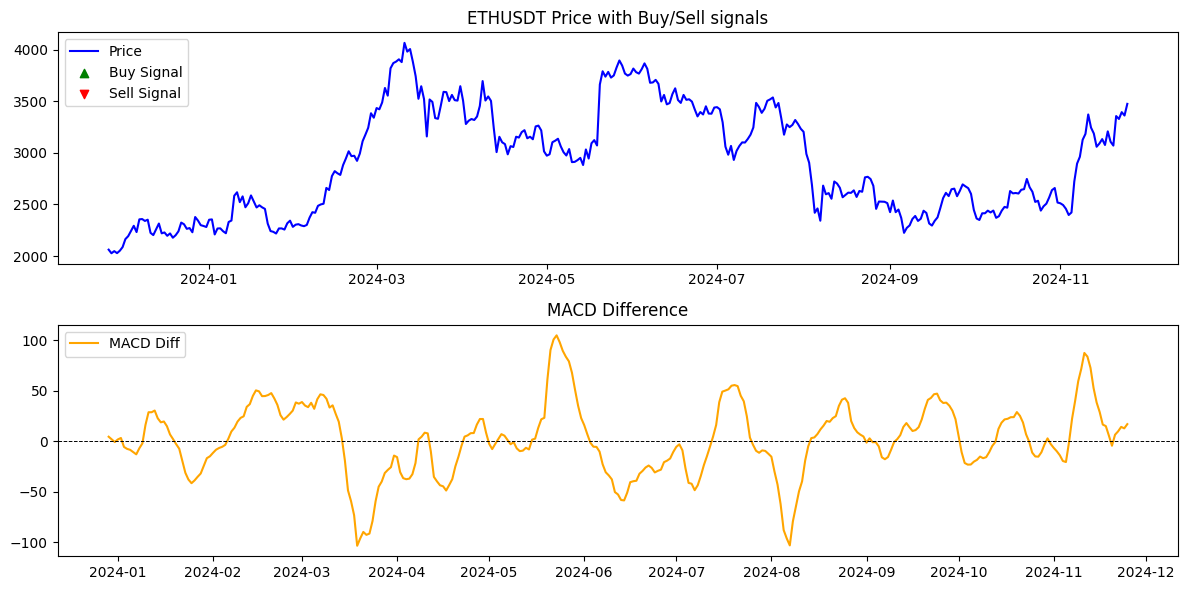

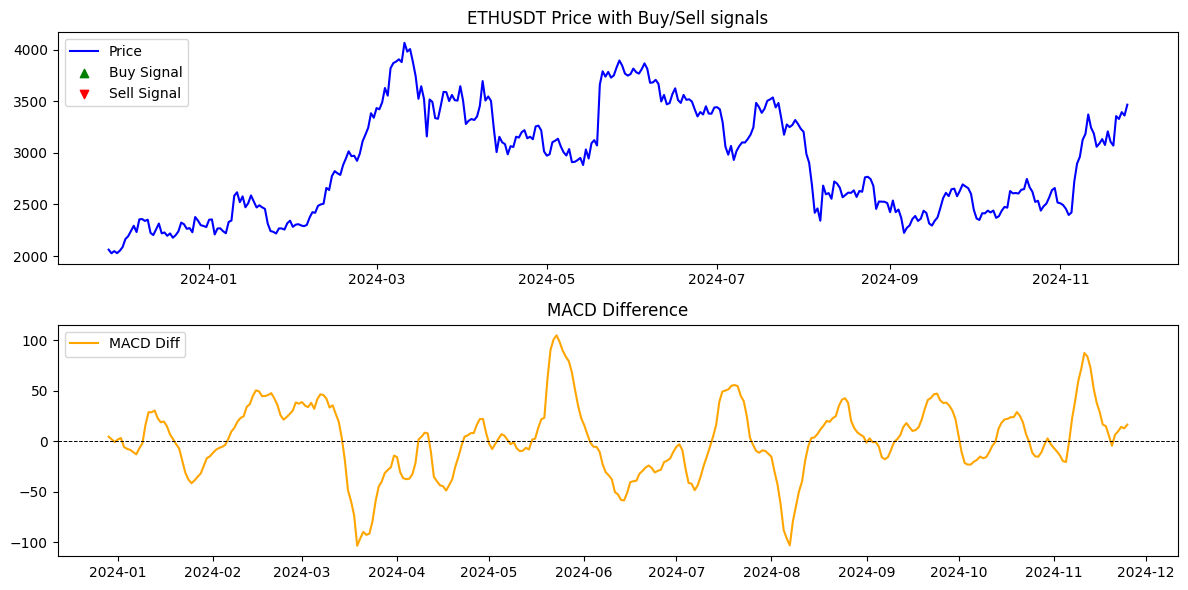

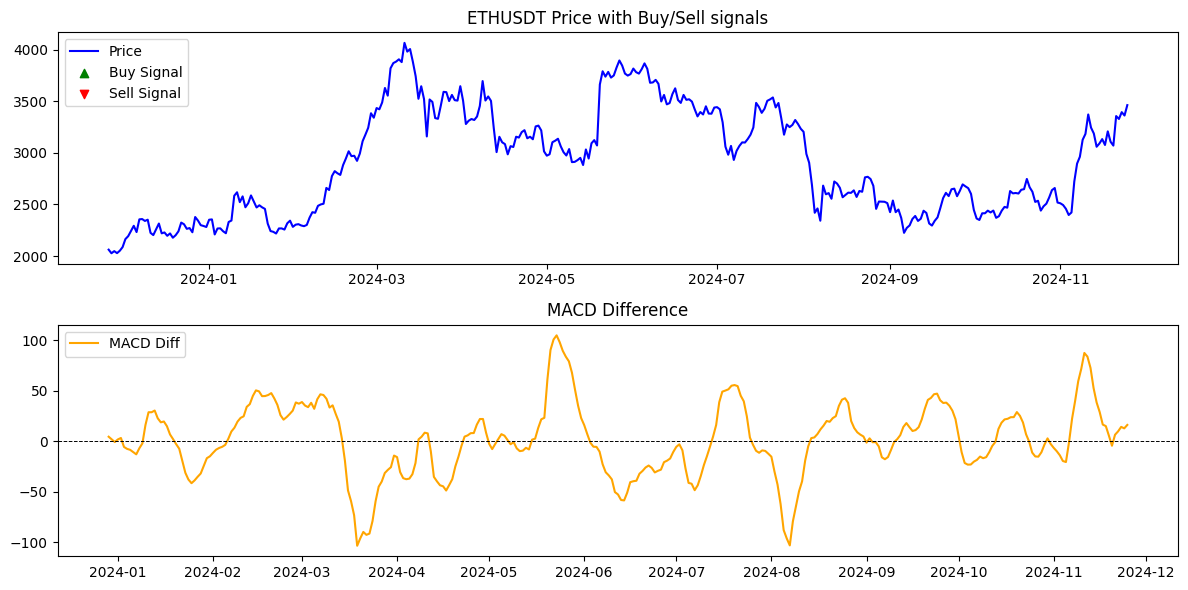

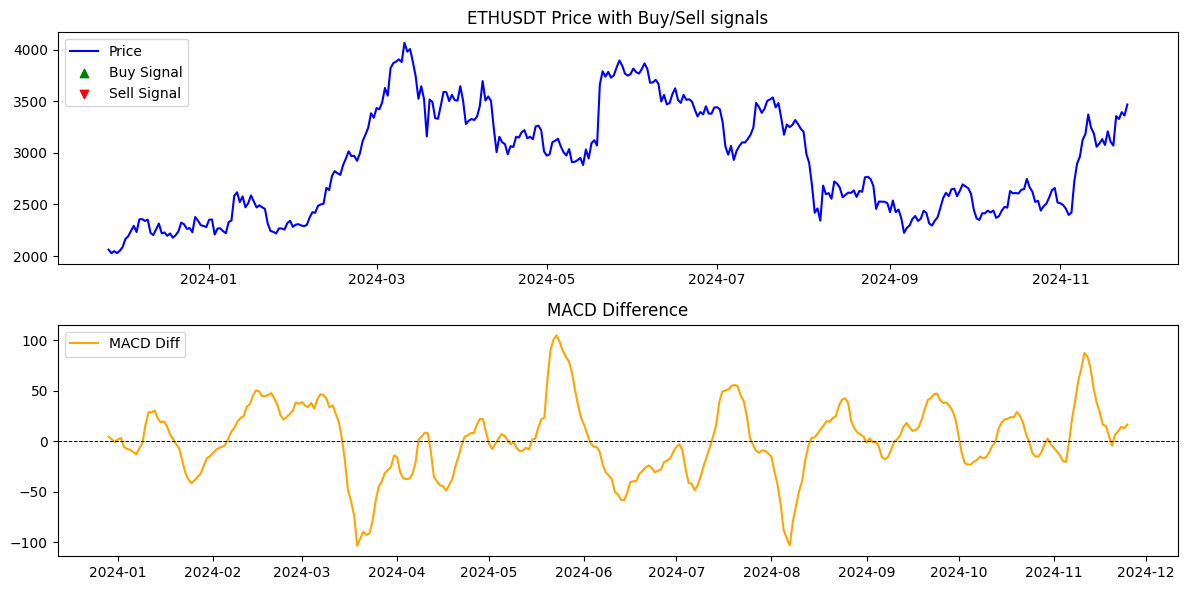

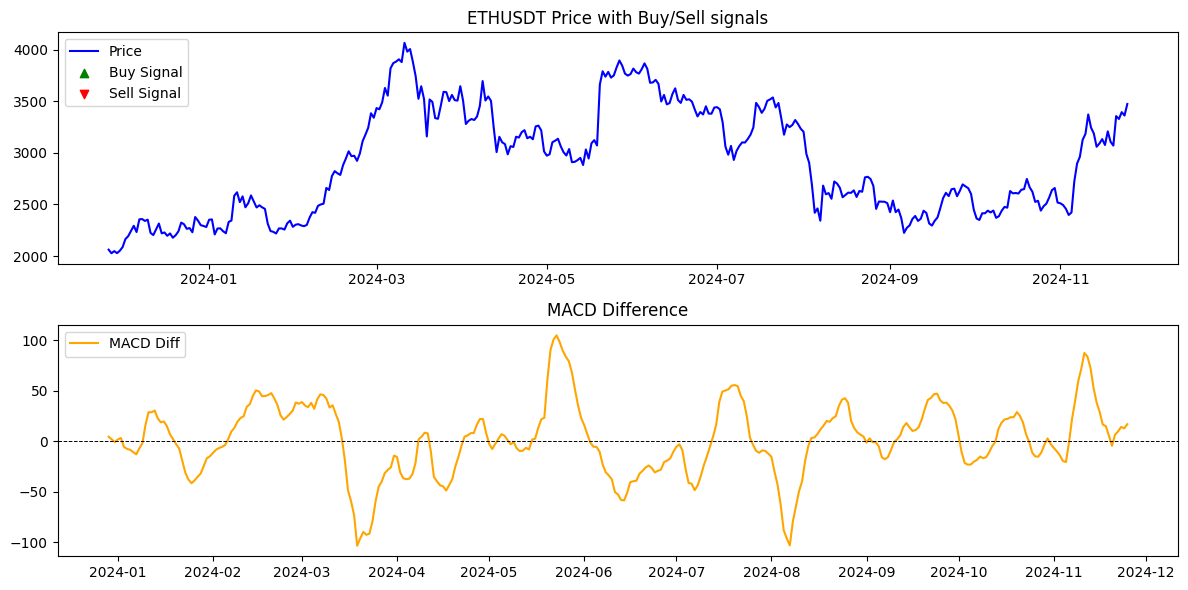

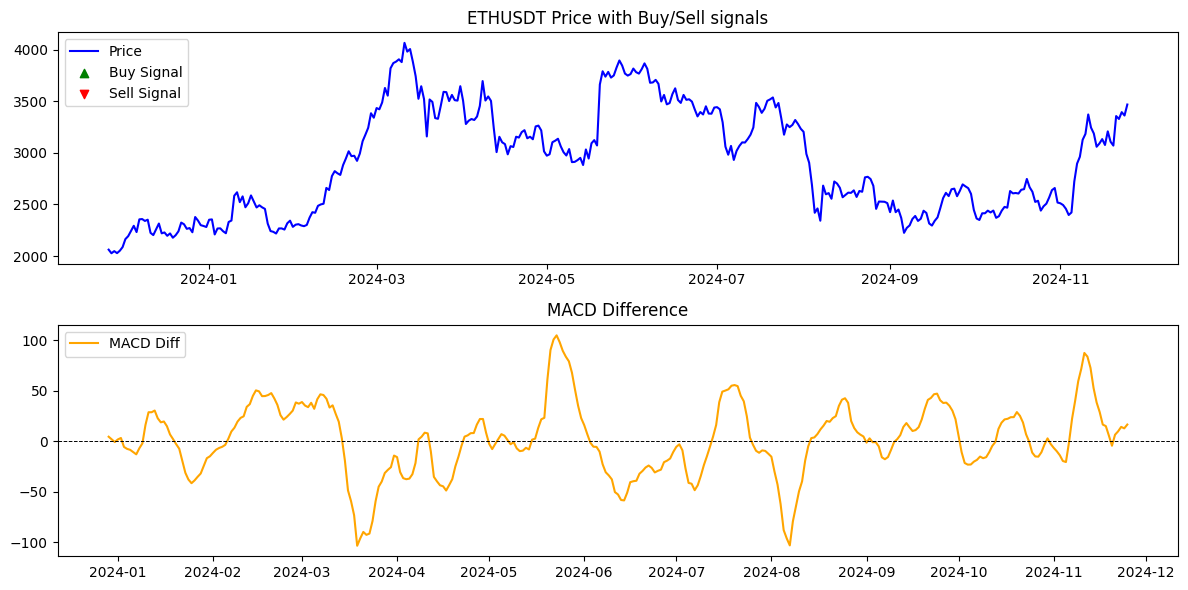

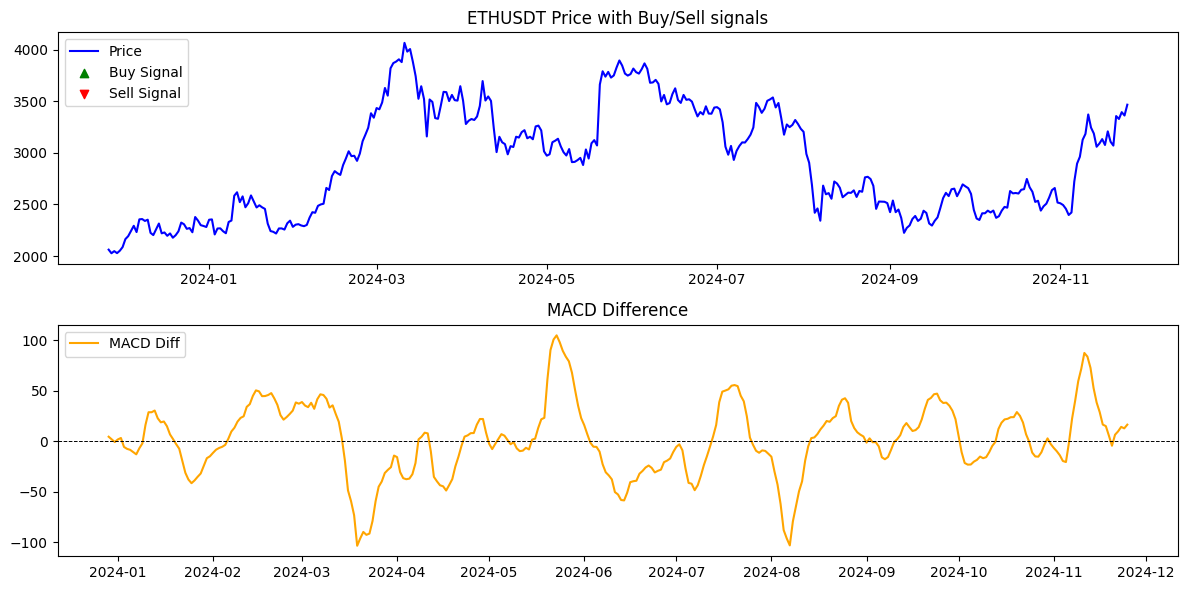

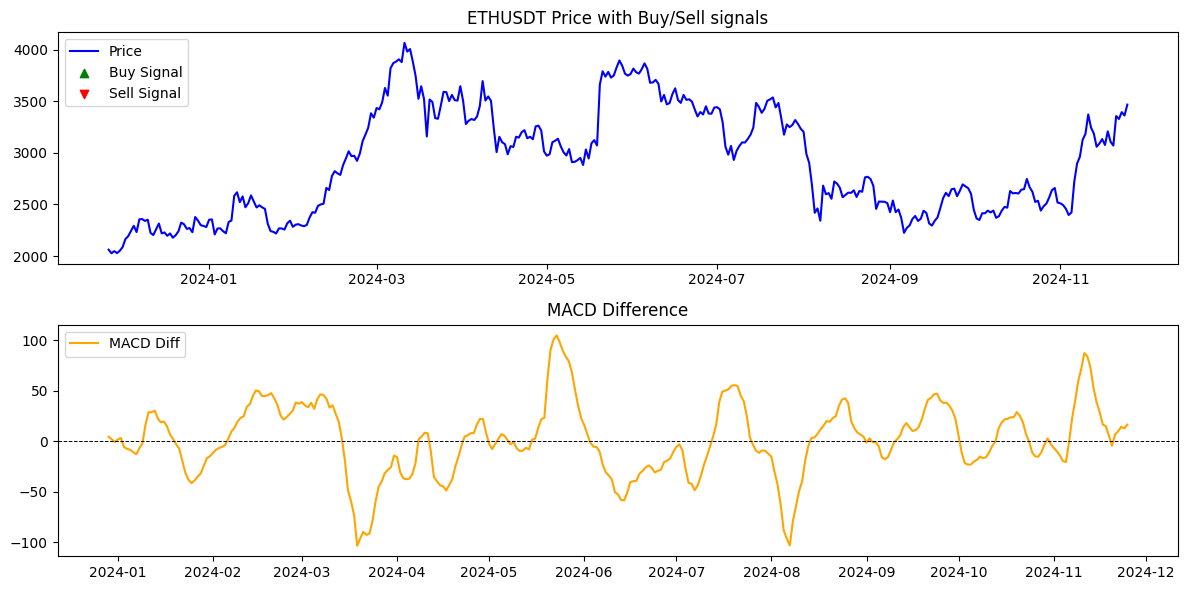

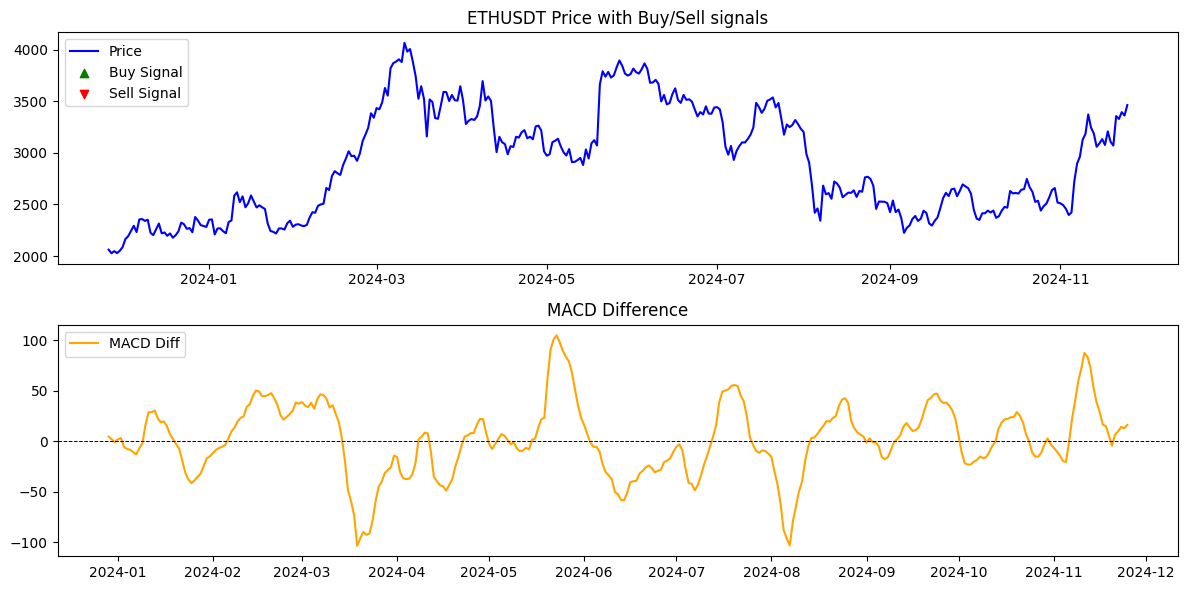

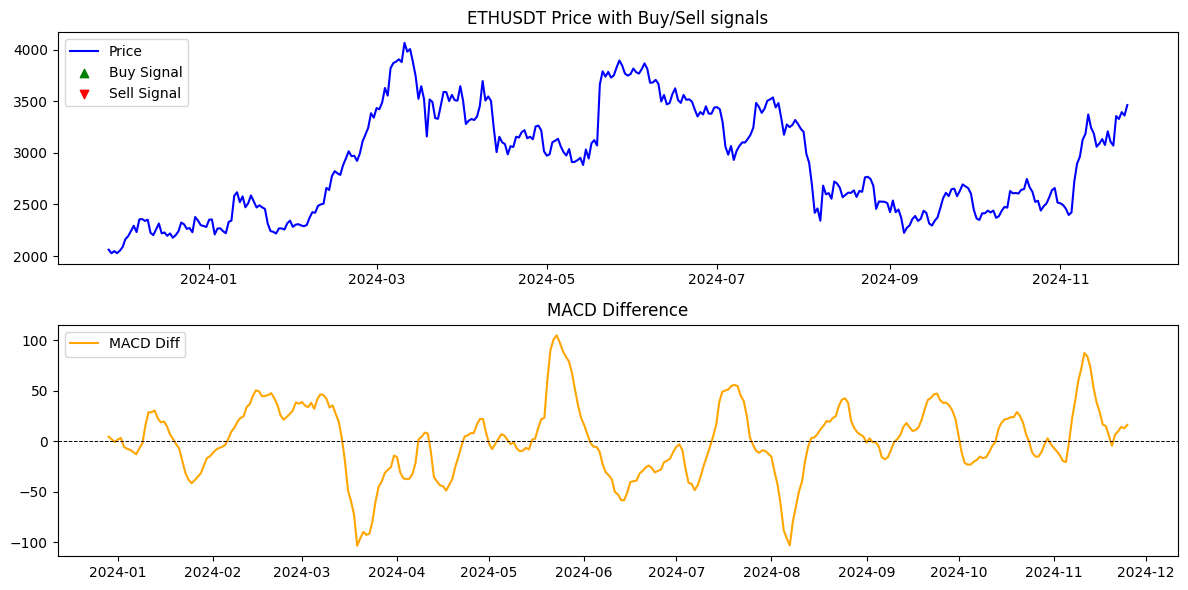

In [ ]:

tradingGraph('ETHUSDT', qty=0.01)